In [24]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax.random import PRNGKey, split
from jax import config, grad
from time import time
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix, generate_sensing_matrices
from loss import create_l2_loss, create_mc_loss, create_gs_loss
from network import init_net, create_network, compute_prefactor, compress_network
from solver import train
from utils import svd, sensing_operator

## Low Rank (Square) Matrix Factorization

In [28]:
key = PRNGKey(0)

r = 5
input_dim = 1000
output_dim = 1000
depth = 3
init_type = "orth"
init_scale = 1e-3

key, data_key = split(key)
target = generate_data(key=data_key, shape=(output_dim, input_dim), rank=r)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network()
l2_loss_fn = create_l2_loss(target)

In [34]:
num_iters = 30000
step_size = 1e1
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

  0%|          | 0/30000 [00:00<?, ?it/s]


KeyboardInterrupt



In [29]:
V = compute_prefactor(init_weights, l2_loss_fn, network_fn, r)
U1 = init_weights[0] @ V / init_scale

In [30]:
plt.imshow(jnp.log10(jnp.abs(U1.T @ weights[0] @ V)))
plt.colorbar()

TypeError: dot_general requires contracting dimensions to have the same shape, got (1000,) and (100,).

In [31]:
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_network_fn = create_network(pre=V1_1.T, post=UL_1)

In [33]:
num_iters = 30000
step_size = 1e1
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    loss_fn=l2_loss_fn,
    network_fn=comp_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    save_weights=False,
)

  0%|          | 0/30000 [00:00<?, ?it/s]


KeyboardInterrupt



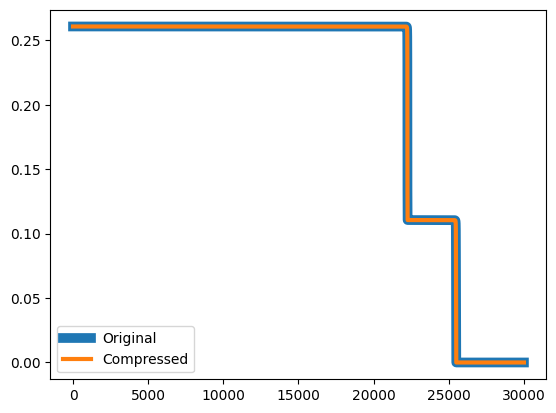

In [8]:
plt.plot(loss_list, linewidth=7, label='Original')
plt.plot(comp_loss_list, linewidth=3, label='Compressed')
plt.legend()

### What if we use a smaller width network (width=2r)

In [9]:
key, weight_key = split(key)
narrow_init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=2*r, depth=depth, init_type="orth", init_scale=init_scale)

In [10]:
num_iters = 30000
step_size = 1e1
narrow_weights, narrow_loss_list, narrow_time_list = train(
    init_weights=narrow_init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

  0%|          | 0/30000 [00:00<?, ?it/s]

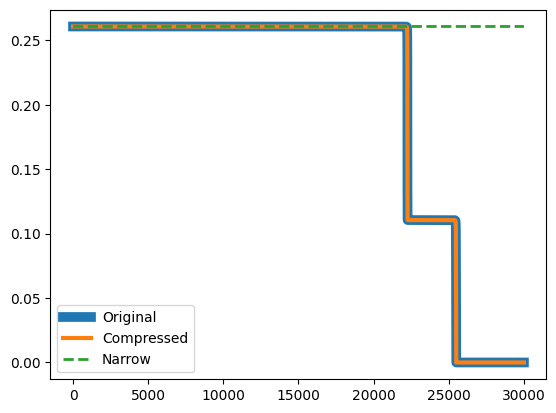

In [11]:
plt.plot(loss_list, linewidth=7, label='Original')
plt.plot(comp_loss_list, linewidth=3, label='Compressed')
plt.plot(narrow_loss_list, linewidth=2, label='Narrow', linestyle='--')
plt.legend()

# Low Rank (Square) Matrix Completion

In [12]:
key, observation_key = split(key)
percent_observed = 0.5
observation_matrix = generate_observation_matrix(observation_key, percent_observed, (output_dim, input_dim))
mc_loss_fn = create_mc_loss(target, observation_matrix)

In [13]:
num_iters = 30000
step_size = 1e1
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=mc_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [14]:
V = compute_prefactor(init_weights, mc_loss_fn, network_fn, r)
U1 = init_weights[0] @ V / init_scale

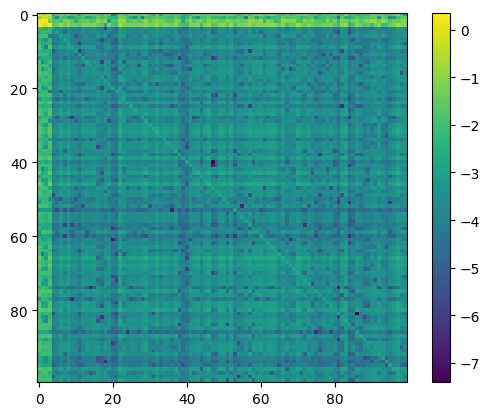

In [15]:
plt.imshow(jnp.log10(jnp.abs(U1.T @ weights[0] @ V)))
plt.colorbar()

In [16]:
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_network_fn = create_network(pre=V1_1.T, post=UL_1)

In [17]:
num_iters = 30000
step_size = 1e1
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    loss_fn=mc_loss_fn,
    network_fn=comp_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    save_weights=True,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

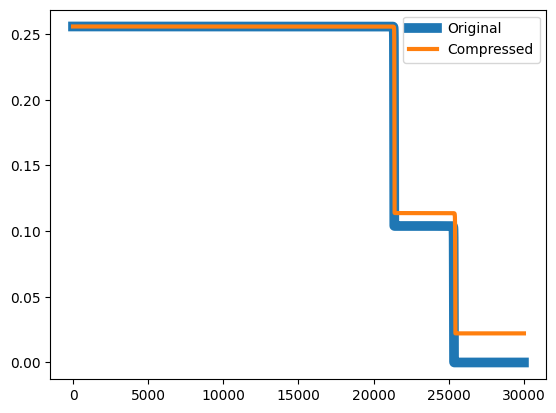

In [18]:
plt.plot(loss_list, linewidth=7, label='Original')
plt.plot(comp_loss_list, linewidth=3, label='Compressed')
plt.legend()

## Can we improve this? (Train factors with discrepant learning rate)

In [19]:
comp_rot_init_weights = [V1_1.T] + comp_init_weights + [UL_1]
comp_rot_network_fn = create_network()

In [20]:
num_iters = 30000
step_size = 1e1
comp_rot_weights, comp_rot_loss_list, comp_rot_time_list = train(
    init_weights=comp_rot_init_weights,
    loss_fn=mc_loss_fn,
    network_fn=comp_rot_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    factors=True,
    save_weights=False
)

  0%|          | 0/30000 [00:00<?, ?it/s]

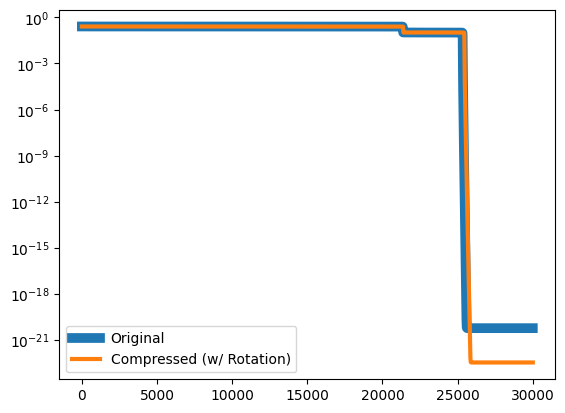

In [22]:
plt.semilogy(loss_list, linewidth=7, label='Original')
plt.semilogy(comp_rot_loss_list, linewidth=3, label='Compressed (w/ Rotation)')
plt.legend()

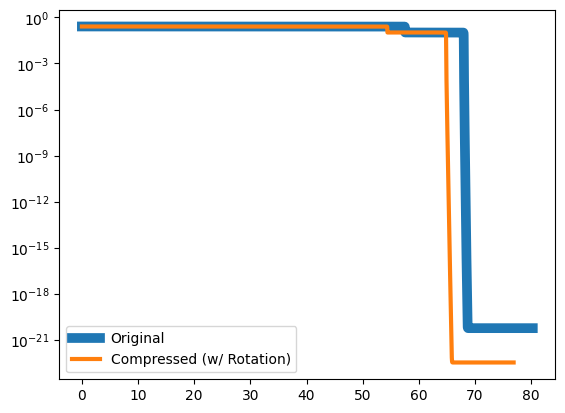

In [23]:
plt.semilogy(time_list, loss_list, linewidth=7, label='Original')
plt.semilogy(comp_rot_time_list, comp_rot_loss_list, linewidth=3, label='Compressed (w/ Rotation)')
plt.legend()